In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string
from tqdm.notebook import trange, tqdm


from wordcloud import WordCloud
from collections import Counter

from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer,LancasterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

from gensim.models import Word2Vec

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
# from tensorflow.keras.models import Model

In [5]:
train = pd.read_csv('train_augmented_synonym.csv')
print(train.shape)
train.head()

(286692, 4)


Unnamed: 0                id  \
0           0  0000997932d777bf   
1           1  000103f0d9cfb60f   
2           2  000113f07ec002fd   
3           3  0001b41b1c6bb37e   
4           4  0001d958c54c6e35   

                                        comment_text  malignant  
0  Explanation\nWhy the edits made under my usern...          0  
1  D'aww! He matches this background colour I'm s...          0  
2  Hey man, I'm really not trying to edit war. It...          0  
3  "\nMore\nI can't make any real suggestions on ...          0  
4  You, sir, are my hero. Any chance you remember...          0

In [6]:
# preprocessing that we are going to do
# 1. convert all letters to lowercase
# 2. calculate the length of sentence

#### Make Strings to Lower Case
train['comment_text'] = train['comment_text'].str.lower()

#### Keep Track of String's Original Length
train['length'] = train['comment_text'].str.len()
## Remove punctuations
train['comment_text'] = train['comment_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

##Remove digits
train['comment_text'] = train['comment_text'].apply(lambda x: x.translate(str.maketrans('','','1234567890')))

train['text_no_stopwords'] = train['comment_text'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in stopwords.words('english')]))

## 
le = WordNetLemmatizer()
train['word_tokens'] = train['text_no_stopwords'].apply(lambda x: le.lemmatize(x))
train['word_tokens'] = train['word_tokens'].apply(lambda x: x.split())

# #### Replace Email Address with 'email'
# train['comment_text'] = train['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','email')

# #### Replace Website Address with 'website'
# train['comment_text'] = train['comment_text'].str.replace(r'^http[s]{0,1}\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','website')

# #### Replace Website Address with 'phonenumber'
# train['comment_text'] = train['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber') # Note, might contain a random 10 digit number.

# #### Replace Numbers with 'numbrs'
# train['comment_text'] = train['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

# #### Special Punctuations are Replaced Explicitly.
# train['comment_text'] = train['comment_text'].str.replace(r'!',' exclamationmark')
# train['comment_text'] = train['comment_text'].str.replace(r'\?',' questionmark')
# train['comment_text'] = train['comment_text'].str.replace(r'\.{1}',' periodmark')
# train['comment_text'] = train['comment_text'].str.replace(r'\.{2,}',' ellipsismark')
# train['comment_text'] = train['comment_text'].str.replace(r'£|\$', ' dollers')

In [9]:
train.to_csv("train_tokenized.csv")

In [8]:
train.head()

Unnamed: 0                id  \
0           0  0000997932d777bf   
1           1  000103f0d9cfb60f   
2           2  000113f07ec002fd   
3           3  0001b41b1c6bb37e   
4           4  0001d958c54c6e35   

                                        comment_text  malignant  length  \
0  explanation\nwhy the edits made under my usern...          0     264   
1  daww he matches this background colour im seem...          0     112   
2  hey man im really not trying to edit war its j...          0     233   
3  \nmore\ni cant make any real suggestions on im...          0     622   
4  you sir are my hero any chance you remember wh...          0      67   

                                   text_no_stopwords  \
0  explanation edits made username hardcore metal...   
1  daww matches background colour im seemingly st...   
2  hey man im really trying edit war guy constant...   
3  cant make real suggestions improvement wondere...   
4                sir hero chance remember page thats   

                                         word_tokens  
0  [explanation, edits, made, username, hardcore,...  
1  [daww, matches, background, colour, im, seemin...  
2  [hey, man, im, really, trying, edit, war, guy,...  
3  [cant, make, real, suggestions, improvement, w...  
4         [sir, hero, chance, remember, page, thats]

In [19]:
toxic_df = train[train["malignant"] == 1]
toxic_df = toxic_df["comment_text"].reset_index(drop=True)

toxic_text = ""

for i in range(len(toxic_df)):
    toxic_text += " " + toxic_df[i]
    
toxic_text[:100]

' cocksucker before you piss around on my work hey... what is it..\n@ | talk .\nwhat is it... an exclus'

In [20]:
tokens = re.findall(r'\w+', toxic_text)
print("Number of toxic tokens = "+"{:,}\n".format(len(tokens)))
print(tokens[:50])

Number of toxic tokens = 8,024,984

['cocksucker', 'before', 'you', 'piss', 'around', 'on', 'my', 'work', 'hey', 'what', 'is', 'it', 'talk', 'what', 'is', 'it', 'an', 'exclusive', 'group', 'of', 'some', 'wp', 'talibans', 'who', 'are', 'good', 'at', 'destroying', 'self', 'appointed', 'purist', 'who', 'gang', 'up', 'any', 'one', 'who', 'asks', 'them', 'questions', 'abt', 'their', 'anti', 'social', 'and', 'destructive', 'non', 'contribution', 'at', 'wp']


In [21]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english') # All English Stopwords
#stop_words = set(stopwords.words('english'))

tokens = [t.lower() for t in tokens if t.lower() not in stop_words]
print(Counter(tokens).most_common(50))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanjiajun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('fuck', 81459), ('wikipedia', 35461), ('nigger', 30640), ('shit', 29278), ('like', 28529), ('suck', 27931), ('fucking', 25680), ('go', 25268), ('u', 23673), ('hate', 22880), ('die', 22139), ('get', 21380), ('ass', 21070), ('one', 19743), ('page', 19703), ('know', 19641), ('gay', 19084), ('information', 17357), ('people', 16295), ('fat', 15341), ('moron', 14640), ('pig', 14528), ('sucks', 13791), ('make', 13537), ('cunt', 13317), ('hi', 12856), ('bitch', 12685), ('wiki', 12590), ('article', 12512), ('bullshit', 12301), ('faggot', 12276), ('technology', 12093), ('talk', 11867), ('user', 11466), ('think', 11013), ('stupid', 10858), ('jew', 10802), ('dick', 10762), ('stop', 10734), ('time', 10680), ('want', 10416), ('would', 10292), ('penis', 10244), ('edit', 9821), ('block', 9687), ('dont', 9578), ('life', 9150), ('cock', 9133), ('even', 8951), ('piece', 8767)]


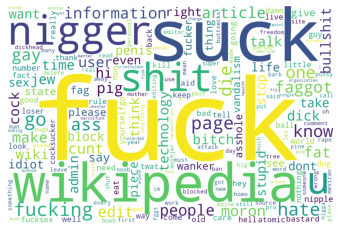

In [26]:
text_wordcloud = " ".join(tokens)
cloud = WordCloud(background_color="white", width=1500, height=1000, collocations = False).generate(text_wordcloud)

plt.imshow(cloud)
plt.axis("off")
plt.show()



In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['word_tokens'], 
                                                     train['malignant'], 
                                                     test_size=0.15, 
                                                     random_state=42)

In [1]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

NameError: name 'X_train' is not defined

In [159]:
import gensim

model = gensim.models.Word2Vec(
    window = 10,
    min_count=2,
    workers=4,
    size = 300
)

model.build_vocab(X_train, progress_per = 1000)

In [160]:
model.train(X_train, total_examples=model.corpus_count, epochs=model.epochs)


(38199840, 39914855)

In [161]:
vocab=model.wv.vocab
print("The total number of words are : ",len(vocab))

The total number of words are :  97888


In [165]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict))

The no of key-value pairs :  97888


{'go': array([-2.0710785 , -0.7664182 ,  0.61931837, -0.89566547, -0.2211853 ,
        -0.24938704,  1.1020331 , -0.60958976, -1.255692  , -0.31713557,
         0.50491595,  0.01480609,  0.24962397,  1.2207437 , -0.56735444,
         0.21492426, -0.53201646, -1.8162113 ,  0.10639234,  0.15144603,
         1.4103941 ,  2.0871587 , -2.1847079 , -0.3789949 , -1.5156119 ,
         0.38854125, -0.9366499 , -1.0507407 , -0.74696296,  1.3586434 ,
        -0.26761436,  0.5044016 ,  0.29778364, -1.0999154 ,  0.06992607,
        -0.6689145 ,  1.004515  , -1.6791844 , -0.39750573, -1.0546576 ,
         0.39797804,  0.25503284,  0.61640966, -0.36775556,  0.84773636,
         0.75825965,  0.41785043,  0.7057743 , -0.6310558 , -1.4845592 ,
        -0.02365769, -1.8661319 ,  0.02407875,  0.9205312 ,  0.7936492 ,
        -1.3752942 , -0.39451697, -0.6271674 , -1.142454  , -1.6648959 ,
        -0.58831763,  0.4482318 ,  0.6370383 ,  0.34166574,  0.19811599,
         0.81974584,  0.14943983, -0.26811033

In [178]:
model.save("word2vec.model")

In [177]:
model.wv.similarity('dog','pet')

0.24866197

In [121]:
maxi=-1
for i,rev in enumerate(X_train):
    if(len(rev)>maxi):
        maxi=len(rev)
print(maxi)

1253


In [ ]:
max_rev_len=1253  # max lenght of a comment
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=100 # embedding dimension as choosen in word2vec constructor

In [ ]:
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.